In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pyFTS.benchmarks import Measures
import math
from pyFTS.common import Util
import datetime
import statistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Aux functions

In [2]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [4]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

## Dataset Smart Home with Weather information

In [5]:
df = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/HomeC.csv')
data = df.drop(labels=['icon','summary','cloudCover', 'House overall [kW]', 'time'], axis=1)
#data = data.loc[0: : 10]
data
data.dropna(inplace=True)
data = clean_dataset(data)
values = data.values
data.head()

/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
0,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
1,0.934333,0.003467,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
2,0.931817,0.003467,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
3,1.022050,0.003483,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
4,1.139400,0.003467,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0


## Dataset Smart Home with Weather information: Preprocessing, Lag = 1, t+1

In [6]:
cols = data.columns
list_cols = list(cols)

In [7]:
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
data_scaled = pd.DataFrame(scaled, columns=list_cols)
# frame as supervised learning
data_scaled = series_to_supervised_miso(data_scaled, 1, 1,endog_var='use [kW]')
data_scaled.head()

,use [kW](t-1),gen [kW](t-1),Dishwasher [kW](t-1),Furnace 1 [kW](t-1),Furnace 2 [kW](t-1),Home office [kW](t-1),Fridge [kW](t-1),Wine cellar [kW](t-1),Garage door [kW](t-1),Kitchen 12 [kW](t-1),...,humidity(t-1),visibility(t-1),apparentTemperature(t-1),pressure(t-1),windSpeed(t-1),windBearing(t-1),precipIntensity(t-1),dewPoint(t-1),precipProbability(t-1),use [kW](t)
1,0.063395,0.005674,0.000024,0.010694,0.077812,0.455455,0.145775,0.005469,0.011999,0.000357,...,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.063497
2,0.063497,0.005647,0.000000,0.010703,0.080202,0.456930,0.145598,0.005469,0.012030,0.000357,...,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.063326
3,0.063326,0.005647,0.000012,0.010694,0.078315,0.458988,0.145050,0.005469,0.011999,0.000371,...,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.069458
4,0.069458,0.005674,0.000012,0.055264,0.086115,0.459520,0.144580,0.005469,0.011923,0.000371,...,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.077433
5,0.077433,0.005647,0.000095,0.122497,0.080412,0.459468,0.144247,0.005364,0.011724,0.000386,...,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.094591


In [8]:
data = series_to_supervised_miso(data, 1, 1,endog_var='use [kW]')
data.head()

,use [kW](t-1),gen [kW](t-1),Dishwasher [kW](t-1),Furnace 1 [kW](t-1),Furnace 2 [kW](t-1),Home office [kW](t-1),Fridge [kW](t-1),Wine cellar [kW](t-1),Garage door [kW](t-1),Kitchen 12 [kW](t-1),...,humidity(t-1),visibility(t-1),apparentTemperature(t-1),pressure(t-1),windSpeed(t-1),windBearing(t-1),precipIntensity(t-1),dewPoint(t-1),precipProbability(t-1),use [kW](t)
1,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.934333
2,0.934333,0.003467,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.931817
3,0.931817,0.003467,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.022050
4,1.022050,0.003483,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.139400
5,1.139400,0.003467,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.391867


In [9]:
round(data.describe(),3)

,use [kW](t-1),gen [kW](t-1),Dishwasher [kW](t-1),Furnace 1 [kW](t-1),Furnace 2 [kW](t-1),Home office [kW](t-1),Fridge [kW](t-1),Wine cellar [kW](t-1),Garage door [kW](t-1),Kitchen 12 [kW](t-1),...,humidity(t-1),visibility(t-1),apparentTemperature(t-1),pressure(t-1),windSpeed(t-1),windBearing(t-1),precipIntensity(t-1),dewPoint(t-1),precipProbability(t-1),use [kW](t)
count,503909.000,503909.000,503909.000,503909.000,503909.000,503909.000,503909.000,503909.000,503909.000,503909.000,...,503909.000,503909.000,503909.000,503909.000,503909.000,503909.000,503909.000,503909.000,503909.000,503909.000
mean,0.859,0.076,0.031,0.099,0.137,0.081,0.064,0.042,0.014,0.003,...,0.664,9.253,48.263,1016.302,6.650,202.357,0.003,38.694,0.056,0.859
std,1.058,0.128,0.191,0.169,0.179,0.104,0.076,0.058,0.014,0.022,...,0.194,1.611,22.028,7.895,3.983,106.521,0.011,19.088,0.166,1.058
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.130,0.270,-32.080,986.400,0.000,0.000,0.000,-27.240,0.000,0.000
25%,0.368,0.003,0.000,0.020,0.064,0.040,0.005,0.007,0.013,0.000,...,0.510,9.420,31.090,1011.290,3.660,148.000,0.000,24.600,0.000,0.368
50%,0.562,0.004,0.000,0.021,0.067,0.042,0.005,0.008,0.013,0.001,...,0.680,10.000,50.320,1016.530,5.930,208.000,0.000,39.030,0.000,0.562
75%,0.970,0.084,0.000,0.069,0.081,0.068,0.125,0.053,0.013,0.001,...,0.840,10.000,66.260,1021.480,8.940,295.000,0.000,54.790,0.000,0.970
max,14.715,0.614,1.402,1.934,0.795,0.972,0.851,1.274,1.089,1.167,...,0.980,10.000,101.120,1042.460,22.910,359.000,0.191,75.490,0.840,14.715


## Model: SARIMAX

### Define SARIMAX parameters

In [10]:
values = data.values
values.shape

(50390, 28)

In [24]:
values = data.values
train_size=int(len(values)*0.30)
test_size = int(len(values)) - train_size
print(test_size)

35273


In [26]:
# split into train and test sets
train_X, train_y = data.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[:train_size], data['use [kW](t-1)'].values[:train_size]
test_X, test_y = data.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[train_size:], data['use [kW](t)'].values[train_size:]

train_y.reshape(-1)
test_y.reshape(-1)


# train_X, train_y = data_scaled.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[:train_size], data_scaled['use [kW](t-1)'].values[:train_size]
# test_X, test_y = data_scaled.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[train_size:], data_scaled['use [kW](t)'].values[train_size:]

# train_y.reshape(-1)
# test_y.reshape(-1)

# split into input (all columns exceptc last one) and outputs (last column)
# train_X, train_y = train_X[:, :-1], train_y[:, -1]
# test_X, test_y = test_X[:, :-1], test_y[:, -1]

# # reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
# train_X = train_X.reshape((train_X.shape[0],train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(15117, 27) (15117,) (35273, 27) (35273,)


In [10]:
# cols = data.columns
# list_cols_exog = list(cols)
# list_cols_exog.remove("use [kW]")

In [11]:
# df_train_X = pd.DataFrame(train_X,columns=list_cols_exog)
# df_test_X = pd.DataFrame(train_X,columns=list_cols_exog)

In [12]:
# list_cols_endog = []
# list_cols_endog.append('use [kW]')
# df_train_y = pd.DataFrame(train_y,columns=list_cols_endog)
# df_test_y = pd.DataFrame(test_y,columns=list_cols_endog)
#df_train_y

In [13]:
# from matplotlib import pyplot
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(df_train_y)
# pyplot.show()

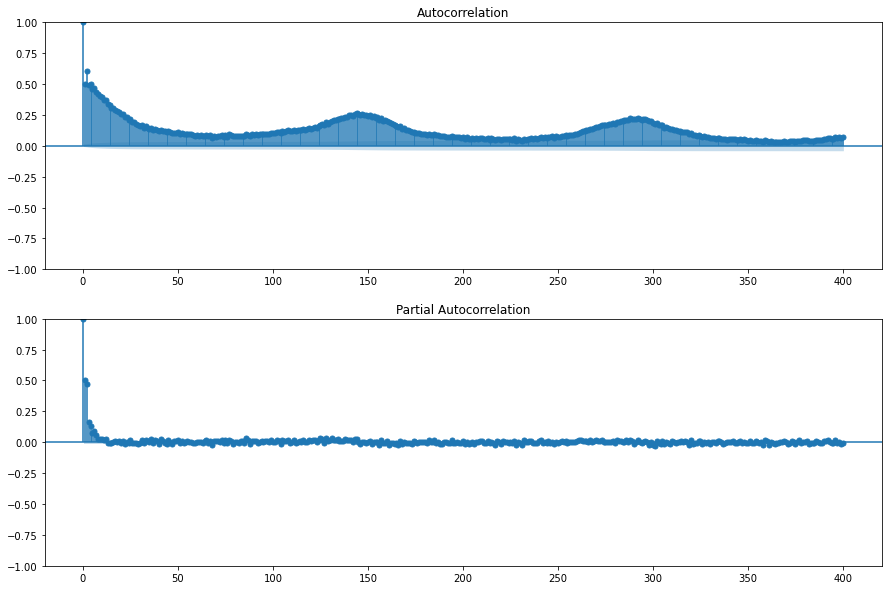

In [16]:
#Correlograms
fig,ax= plt.subplots(2,1, figsize=(15,10))
fig=sm.tsa.graphics.plot_acf(train_y, lags=400, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(train_y, lags=400, ax=ax[1])
plt.show()

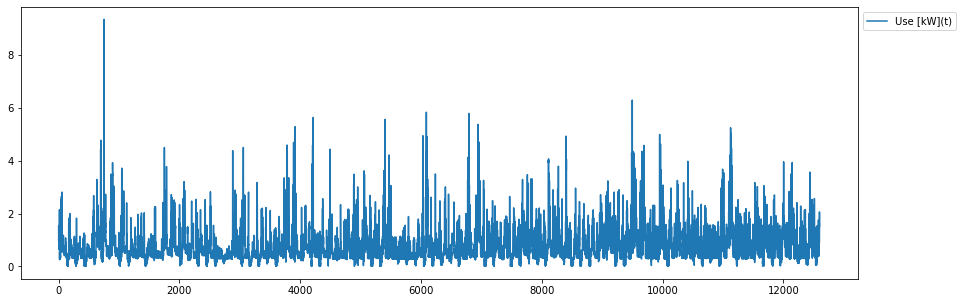

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 5])
ax.plot(test_y, label='Use [kW](t)')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

In [27]:
# # # m = 7 => daily
# # # m = 52 => weekly
# sarimax_model = auto_arima(train_y,
#                        exogenous= train_X,
#                        test='adf',
#                        start_p=0,
#                        start_q=0,
#                        max_p=5,
#                        max_q=5,
#                        start_Q=0,
#                        start_P=0,
#                        max_P=5,
#                        max_Q=5,
#                        m=7,
#                        seasonal=True,
#                        d=None,
#                        D=1,
#                        max_D=5,
#                        trace=True,
#                        error_action='ignore',
#                        suppress_warnings=True,
#                        stepwise=True)
#                        #n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=-319943.969, Time=109.59 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-199807.897, Time=492.34 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=-320083.498, Time=109.37 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=-319945.969, Time=60.07 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=-320083.155, Time=17.74 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=-320082.606, Time=111.74 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=-320081.935, Time=169.46 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=-320082.962, Time=107.11 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=-320080.169, Time=178.05 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=-319952.589, Time=123.20 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=599200193706.967, Time=437.10 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=-131693.711, Time=300.40 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=4003.858, Time=106.56 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept 

In [20]:
#ARIMA(0,0,1)(3,1,1)[7] intercept   : AIC=-90795.546, Time=847.26 sec
#ARIMA(0,0,1)(4,1,3)[7] intercept   : AIC=-54962.100, Time=787.74 sec

#sarimax_model.summary()

In [21]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# model= SARIMAX(endog=train_y, 
#  exog=train_X,
#  order=(0,0,1),
#  seasonal_order=(4,1,3,7),
#  enforce_invertibility=False, 
#  enforce_stationarity=False)

In [22]:
# results = model.fit(disp=True)

/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                37792
Model:             SARIMAX(0, 0, 1)x(4, 1, [1, 2, 3], 7)   Log Likelihood               47530.529
Date:                                   Fri, 17 Sep 2021   AIC                         -94989.058
Time:                                           17:16:04   BIC                         -94681.657
Sample:                                                0   HQIC                        -94891.492
                                                 - 37792                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9549      0.002    487.579      0.000       0.951       0.959
x2             0.0003      0.000      0.961      0.337      -0.000       0.001
x3            -0.0031      0.001     -2.959      0.003      -0.005      -0.001
x4             0.0010      0.002      0.489      0.625      -0.003       0.005
x5            -0.0026      0.001     -2.422      0.015      -0.005      -0.000
x6             0.0019      0.001      2.534      0.011       0.000       0.003
x7            -0.0088      0.002     -5.433      0.000      -0.012      -0.006
x8             0.0019      0.003      0.639      0.523      -0.004       0.008
x9             0.0499      0.011      4.443      0.000       0.028       0.072
x10           -0.0109      0.006     -1.853      0.064      -0.022       0.001
x11           -0.0145      0.006     -2.379      0.017      -0.027      -0.003
x12            0.0019      0.003      0.729      0.466      -0.003       0.007
x13            0.0113      0.003      3.248      0.001       0.004       0.018
x14           -0.0141      0.003     -5.542      0.000      -0.019      -0.009
x15           -0.0357      0.004     -8.902      0.000      -0.044      -0.028
x16            0.0044      0.001      8.461      0.000       0.003       0.005
x17            0.0003      0.000      0.961      0.337      -0.000       0.001
x18            0.1658      0.012     13.437      0.000       0.142       0.190
x19            0.0319      0.004      8.594      0.000       0.025       0.039
x20            0.0048      0.001      4.360      0.000       0.003       0.007
x21           -0.1040      0.010    -10.623      0.000      -0.123      -0.085
x22           -0.0004      0.001     -0.305      0.761      -0.003       0.002
x23           -0.0039      0.001     -3.903      0.000      -0.006      -0.002
x24           -0.0004      0.000     -0.873      0.383      -0.001       0.001
x25           -0.0023      0.002     -1.063      0.288      -0.006       0.002
x26           -0.0742      0.009     -7.949      0.000      -0.092      -0.056
x27            0.0005      0.001      0.528      0.598      -0.001       0.002
ma.L1         -0.7134      0.002   -364.814      0.000      -0.717      -0.710
ar.S.L7       -0.3778      0.122     -3.105      0.002      -0.616      -0.139
ar.S.L14      -0.1983      0.075     -2.647      0.008      -0.345      -0.051
ar.S.L21       0.0472      0.004     10.715      0.000       0.039       0.056
ar.S.L28      -0.0135      0.007     -1.978      0.048      -0.027      -0.000
ma.S.L7       -0.6059      0.122     -4.980      0.000      -0.844      -0.367
ma.S.L14      -0.1715      0.074     -2.319      0.020      -0.316      -0.027
ma.S.L21      -0.2253      0.077     -2.935      0.003      -0.376      -0.075
sigma2         0.0047   1.25e-05    375.517      0.000       0.005  

In [24]:
# steps = -1
# yhat = results.predict(start=train_size, end=train_size+test_size+(steps),exog=test_X)
# #yhat

In [25]:
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# # invert scaling for forecast
# inv_yhat = np.concatenate((yhat.reshape(len(yhat),1), test_X[:, 1:]), axis=1)
# print(inv_yhat.shape)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual - observed data
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

(12598, 27)


In [26]:
# rmse = Measures.rmse(inv_yhat,inv_y)
# mape = Measures.mape(inv_yhat,inv_y)
# smape = Measures.smape(inv_yhat,inv_y)
# print('Test RMSE: %.3f' % rmse)
# print('Test MAPE: %.3f' % mape)
# print('Test SMAPE: %.3f' % smape)

Test RMSE: 0.571
Test MAPE: 54.421
Test SMAPE: 21.089


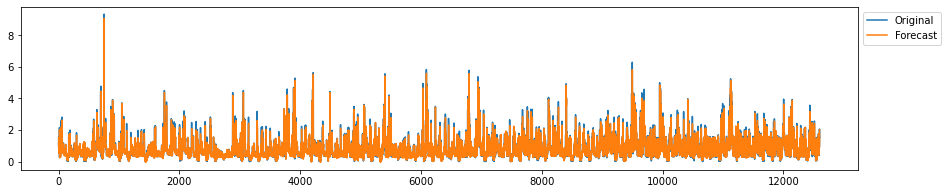

In [27]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
# ax.plot(inv_y, label='Original')
# ax.plot(inv_yhat, label='Forecast')
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
# plt.show()

## Model: SARIMAX - Final model

In [10]:
#ARIMA(0,0,1)(0,1,1)[7] ==> 1.298772	0.719836	284.08034	27.289521        
#ARIMA(0,0,1)(0,1,0)[7] ==> 1.385476	0.849953	338.81325	36.947232
#ARIMA(0,0,1)(1,1,0)[7] ==> 1.369081	0.826415	325.134299	34.910417
#ARIMA(0,0,1)(0,1,1)[7] ==> 1.315577	0.738525	287.562907	29.931525

In [11]:
def train_sarimax(endog, exog, order, seasonal_order):
    model=sm.tsa.SARIMAX(endog = endog, exog = exog, 
                          order=order,
                          seasonal_order=seasonal_order, 
                         enforce_invertibility=False, 
                         enforce_stationarity=False)
    sarimax = model.fit()
    return sarimax


def test_sarimax(model,start,end,exog):
    forecasts = model.predict(start=start, end=end, exog=exog)
    return forecasts
    

In [12]:
def transform_original(test_X,test_y,yhat):
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat.reshape(len(yhat),1), test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual - observed data
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
#     ax.plot(inv_y, label='Original')
#     ax.plot(inv_yhat, label='Forecast')
#     handles, labels = ax.get_legend_handles_labels()
#     lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
#     plt.show()
    
    return inv_y,inv_yhat

## Sliding Window PyFTS: SARIMAX

In [13]:
result = {
     "window": [],
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": [],
     "nrmse":[]
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data_scaled, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        start = len(ttrain)
        end = len(ttrain)+ len(ttest) -1
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model = train_sarimax(ttrain.loc[:,'use [kW](t-1)'], 
                              ttrain.loc[:,'gen [kW](t-1)':'precipProbability(t-1)'], 
                              [0,0,1], 
                              [1,1,1,7])
        yhat = test_sarimax(model, start, end, ttest.loc[:,'gen [kW](t-1)':'precipProbability(t-1)']) 
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")

        test_X = ttest.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values
        test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
        test_y = ttest['use [kW](t)'].values 

        appliances,forecast = transform_original(test_X = test_X,test_y = test_y,yhat = yhat.values)
        
        rmse = Measures.rmse(appliances,forecast)
        mape = Measures.mape(appliances,forecast)
        smape = Measures.smape(appliances,forecast)
        
        forecast = pd.DataFrame(forecast)
        forecast.fillna(forecast.mean(),inplace=True)
        forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(appliances, forecast)
                
        nrmse = cal_nrmse(rmse, appliances)
                
        result["rmse"].append(round(rmse,3))
        result["mae"].append(round(mae,3))
        result["mape"].append(round(mape,3))
        result["smape"].append(round(smape,3))
        result["nrmse"].append(round(nrmse,3))
        result["window"].append(ct)

measures = pd.DataFrame(result)


--------------------
training window 0


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:12:02] getting statistics
--------------------
training window 16796


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:16:08] getting statistics
--------------------
training window 33592


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:20:11] getting statistics
--------------------
training window 50388


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:23:55] getting statistics
--------------------
training window 67184


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:27:48] getting statistics
--------------------
training window 83980


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:31:33] getting statistics
--------------------
training window 100776


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:35:26] getting statistics
--------------------
training window 117572


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:38:52] getting statistics
--------------------
training window 134368


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:43:05] getting statistics
--------------------
training window 151164


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:46:31] getting statistics
--------------------
training window 167960


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:50:36] getting statistics
--------------------
training window 184756


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:54:51] getting statistics
--------------------
training window 201552


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:58:35] getting statistics
--------------------
training window 218348


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:02:30] getting statistics
--------------------
training window 235144


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:06:17] getting statistics
--------------------
training window 251940


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:09:57] getting statistics
--------------------
training window 268736


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:13:41] getting statistics
--------------------
training window 285532


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:17:30] getting statistics
--------------------
training window 302328


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:21:15] getting statistics
--------------------
training window 319124


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:24:58] getting statistics
--------------------
training window 335920


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:30:24] getting statistics
--------------------
training window 352716


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:36:06] getting statistics
--------------------
training window 369512


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:41:41] getting statistics
--------------------
training window 386308


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:45:25] getting statistics
--------------------
training window 403104


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 00:02:04] getting statistics
--------------------
training window 419900


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 00:08:40] getting statistics
--------------------
training window 436696


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 00:15:39] getting statistics
--------------------
training window 453492


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 00:20:10] getting statistics
--------------------
training window 470288


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 00:23:50] getting statistics
--------------------
training window 487084


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 00:27:26] getting statistics


In [14]:
measures

,window,rmse,mae,mape,smape,nrmse
0,0,2.386,1.553,223.217,36.262,0.527
1,16796,0.446,0.261,116.907,16.132,0.057
2,33592,0.578,0.398,178.838,43.052,0.147
3,50388,1.508,0.678,66.686,22.461,0.249
4,67184,0.413,0.286,139.377,18.647,0.064
5,83980,0.274,0.208,123.044,36.507,0.075
6,100776,0.376,0.184,50.489,12.734,0.066
7,117572,0.446,0.215,31.037,12.974,0.073
8,134368,0.355,0.256,179.854,23.123,0.075
9,151164,0.693,0.456,121.922,59.573,0.059


In [16]:
#measures.to_csv (r'win_sarimax_ksh_10min.csv', index = False, header=True)

In [15]:
measures.to_csv (r'win_sarimax_ksh_1min.csv', index = False, header=True)

### Mean Statistics SARIMAX

In [16]:
final_result = {
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": [],
     "nrmse":[],
     "rmse_std": [],
     "mae_std": [],
     "mape_std": [],
     "smape_std": [],
     "nrmse_std": []
}

final_result["rmse"].append(round(statistics.mean(measures['rmse']),3))
final_result["mape"].append(round(statistics.mean(measures['mape']),3))
final_result["smape"].append(round(statistics.mean(measures['smape']),3))
final_result["mae"].append(round(statistics.mean(measures['mae']),3))
final_result["nrmse"].append(round(statistics.mean(measures['nrmse']),3))

final_result["rmse_std"].append(round(statistics.stdev(measures['rmse']),3))
final_result["mape_std"].append(round(statistics.stdev(measures['mape']),3))
final_result["smape_std"].append(round(statistics.stdev(measures['smape']),3))
final_result["mae_std"].append(round(statistics.stdev(measures['mae']),3))
final_result["nrmse_std"].append(round(statistics.stdev(measures['nrmse']),3))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics SARIMAX (test): ")
final_measures_pca

Mean Statistics SARIMAX (test): 


,rmse,mae,mape,smape,nrmse,rmse_std,mae_std,mape_std,smape_std,nrmse_std
0,0.663,0.407,170.108,29.089,0.106,0.494,0.327,164.867,15.831,0.092


In [18]:
#final_measures_pca.to_csv (r'sarimax_ksh_10mim.csv', index = False, header=True)

In [17]:
final_measures_pca.to_csv (r'sarimax_ksh_1mim.csv', index = False, header=True)